In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
%matplotlib inline

### Importacion de las tablas de datos

In [2]:
atl = pd.read_csv("/home/mcorral/FES/amv_2019_2/olympics/athlete_events.csv")
reg = pd.read_csv("/home/mcorral/FES/amv_2019_2/olympics/noc_regions.csv")

### Imputación variable discreta (medallas)

In [3]:
atl['Medal'] = atl['Medal'].fillna('Ninguna')

In [4]:
atl = atl.dropna()

### Naturaleza de las variables

In [5]:
atl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206165 entries, 0 to 271115
Data columns (total 15 columns):
ID        206165 non-null int64
Name      206165 non-null object
Sex       206165 non-null object
Age       206165 non-null float64
Height    206165 non-null float64
Weight    206165 non-null float64
Team      206165 non-null object
NOC       206165 non-null object
Games     206165 non-null object
Year      206165 non-null int64
Season    206165 non-null object
City      206165 non-null object
Sport     206165 non-null object
Event     206165 non-null object
Medal     206165 non-null object
dtypes: float64(3), int64(2), object(10)
memory usage: 25.2+ MB


In [6]:
1 - atl.count()/atl.shape[0]

ID        0.0
Name      0.0
Sex       0.0
Age       0.0
Height    0.0
Weight    0.0
Team      0.0
NOC       0.0
Games     0.0
Year      0.0
Season    0.0
City      0.0
Sport     0.0
Event     0.0
Medal     0.0
dtype: float64

### Imputacion de variables

In [98]:
atl_cont = ['Age','Height','Weight']
atl_dis = [x for x in atl.columns if x not in atl_cont]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f35064bf080>,
      dtype=object)

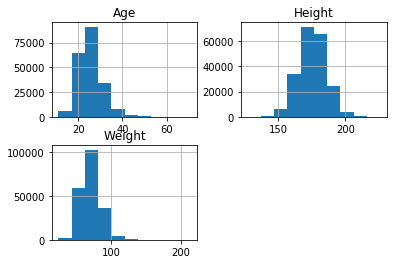

In [99]:
atl[atl_cont].hist()

### Inputacion de las columnas continuas, con la media

In [100]:
for x in atl_cont:
    atl[x] = atl[x].fillna(atl[x].mean())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3506b95048>,
      dtype=object)

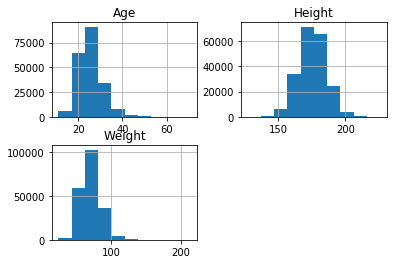

In [101]:
atl[atl_cont].hist()

## Análisis Factorial

In [102]:
df = atl[atl_cont]

In [103]:
sc = StandardScaler()
sc.fit(df)
Xs = pd.DataFrame(sc.transform(df),columns=df.columns)

## Componentes principales 

In [117]:
pca =PCA()
pca.fit(Xs)
Xp=pd.DataFrame(pca.transform(Xs),columns=['p%d'%i for i in range(1,4)])

In [106]:
Xp.corr()

,p1,p2,p3
p1,1.000000e+00,2.585752e-16,-7.309960e-16
p2,2.585752e-16,1.000000e+00,2.892992e-17
p3,-7.309960e-16,2.892992e-17,1.000000e+00


In [107]:
pca.explained_variance_ratio_

array([0.62290386, 0.31037162, 0.06672452])

In [108]:
np.cumsum(pca.explained_variance_ratio_)

array([0.62290386, 0.93327548, 1.        ])

In [110]:
fa =FactorAnalyzer()

fa.analyze(Xs,2,rotation='varimax')

fa.loadings

,Factor1,Factor2
Age,0.094957,0.309778
Height,0.877341,0.188440
Weight,0.814549,0.434806


In [111]:
aux = Xp.sample(200)

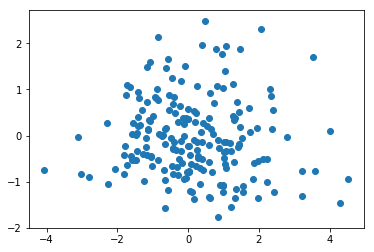

In [112]:
plt.scatter(aux['p1'],aux['p2'])

## Clusters

In [23]:
ls = []
for x in range(2,10) :
    km = KMeans(n_clusters= x)
    km.fit(Xs)
    ls.append(km.inertia_)

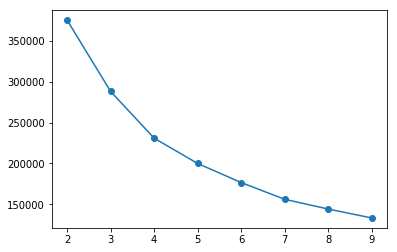

In [24]:
plt.plot(range(2,10),ls,marker='o')

In [131]:
gmm = GaussianMixture(n_components=4)

gmm.fit(Xs)

Xs['gmm']=gmm.predict(Xs)
Xp['gmm']=gmm.predict(Xs)

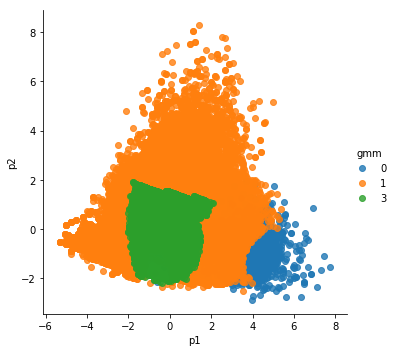

In [132]:
sns.lmplot('p1','p2',Xp,hue='gmm',fit_reg=False)

In [134]:
Xs.groupby('gmm').mean()

,Age,Height,Weight
gmm,,,
0,0.078658,1.907950,2.840923
1,-0.275959,-0.369146,-0.442344
2,1.481687,0.241167,0.666427
3,-0.162314,1.171169,1.024542


In [120]:
atl.head(1)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,Ninguna


In [135]:
sport = Xs.merge(atl[['Sport']],how='left',left_index=True,right_index=True)
medal = Xs.merge(atl[['Medal']],how='left',left_index=True,right_index=True)
sex =  Xs.merge(atl[['Sex']],how='left',left_index=True,right_index=True)

In [147]:
aux2 = sport.pivot_table(index='Sport',columns='gmm',aggfunc='count',values='Age').fillna(0).reset_index()

In [151]:
for x in range(4):
    aux2[x]= aux2[x]/aux2.sum(axis = 1)

In [152]:
aux2

gmm,Sport,0,1,2,3
0,Alpine Skiing,0.014916,0.688029,0.468531,0.998536
1,Archery,0.011380,0.704311,0.439624,0.995002
2,Art Competitions,0.000000,0.666667,0.521739,0.716263
3,Athletics,0.014098,0.686504,0.478899,0.999707
4,Badminton,0.019173,0.670769,0.424086,0.993982
5,Baseball,0.022796,0.715371,0.457172,0.988070
6,Basketball,0.015189,0.692607,0.511829,0.997091
7,Beach Volleyball,0.005025,0.727263,0.432254,0.981267
8,Biathlon,0.012059,0.703778,0.501147,0.997552
9,Bobsleigh,0.012315,0.690144,0.486234,0.995360


In [139]:
aux2

atl.Sport.value_counts()/atl.Sport.count()

Athletics                    0.157030
Swimming                     0.091073
Gymnastics                   0.088623
Rowing                       0.037785
Cycling                      0.037713
Cross Country Skiing         0.036519
Shooting                     0.035215
Fencing                      0.031708
Alpine Skiing                0.030665
Canoeing                     0.026920
Wrestling                    0.025155
Sailing                      0.023588
Biathlon                     0.022385
Ice Hockey                   0.022210
Equestrianism                0.022084
Football                     0.021551
Speed Skating                0.021342
Boxing                       0.021163
Hockey                       0.020682
Basketball                   0.017792
Judo                         0.016327
Handball                     0.016099
Volleyball                   0.015895
Weightlifting                0.014425
Water Polo                   0.013188
Bobsleigh                    0.010695
Diving      

# Perfilamiento:

In [136]:
aux2 = medal.pivot_table(index='Medal',columns='gmm',aggfunc='count',values='Age').reset_index()

aux2 = aux2[aux2.Medal != 'Ninguna']

for x in range(4):
    aux2[x]= aux2[x]/aux2[x].sum()

print(aux2)

gmm   Medal         0         1         2         3
0    Bronze  0.349835  0.335145  0.332824  0.343473
1      Gold  0.343234  0.338551  0.332518  0.324115
3    Silver  0.306931  0.326303  0.334658  0.332412


#### Podemos ver que la estatura,peso y edad no influyen en la cantidad de medallas ganadas

In [137]:
aux2 = sex.pivot_table(index='Sex',columns='gmm',aggfunc='count',values='Age').reset_index()

for x in range(4):
    aux2[x]= aux2[x]/aux2[x].sum()


print(aux2)
print('\n')
print(atl.Sex.value_counts()/atl.Sex.count())

gmm Sex         0         1         2         3
0     F  0.309398  0.319801  0.318018  0.319184
1     M  0.690602  0.680199  0.681982  0.680816


M    0.676419
F    0.323581
Name: Sex, dtype: float64


#### Podemos ver que la estatura,peso y edad no discrimina el sexo

### Clusters
#### 0- Pesos MUY pesados
#### 1- Basketbolista
#### 2 - Veterano
#### 3 - Pesos pesados